In [668]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [669]:
# raw values of gain and offset for each channel
GAIN_CH0 = 1843252.0855343048
GAIN_CH1 = 1872501.4373586383
GAIN_CH2 = 1848654.547552344

OFFSET_CH0 = 8383140.43862641
OFFSET_CH1 = 8401034.901094487
OFFSET_CH2 = 8382671.373877345

TIMER_MAX = 2**24
TIMER_FREQ = 1e6

In [670]:
def import_24bit_data(fn):
    table = pd.read_csv(fn, sep=',', skiprows = 0)
    table.columns = np.arange(0,422,1)
    
    data_ch0 = []
    for i in range(len(table[0])):
        for j in range(60):
            data_ch0.append(table[j][i])
            
    data_ch1 = []
    for i in range(len(table[60])):
        for j in range(60):
            data_ch1.append(table[60 + j][i])
            
    data_ch2 = []
    for i in range(len(table[120])):
        for j in range(60):
            data_ch2.append(table[120 +j][i])
            
    clock_ticks = []
    for i in range(len(table[360])):
        for j in range(60):
            clock_ticks.append(table[360+j][i])

    data_ch0 = np.array(data_ch0)
    data_ch1 = np.array(data_ch1)
    data_ch2 = np.array(data_ch2)
    clock_ticks = np.array(clock_ticks)
    times_1 = np.array(table[420])
    times_2 = np.array(table[421])

    clock_float = clock_ticks.astype(float)

    clock_ticks_diff = []
    for i in range(len(clock_ticks) - 1):
        diff = clock_float[i+1] - clock_float[i]
        if diff > 0:
            clock_ticks_diff.append(diff)

    clock_rate = 10**6
    
    #clock_ticks_diff = [clock_float[i+1] - clock_float[i] for i in range(len(clock_ticks)-1)]
    print("NUMBER OF DATA POINTS:", len(data_ch1))
    print("MEAN CLOCK TICK DIFF:", np.mean(clock_ticks_diff))
    print("MEAN PERIOD:", np.mean(clock_ticks_diff)/(clock_rate))
    print("MEAN FREQ (Hz):", 1/(np.mean(clock_ticks_diff)/(clock_rate)))
        
    return data_ch0, data_ch1, data_ch2, clock_ticks, times_1, times_2, 1/(np.mean(clock_ticks_diff)/clock_rate)

    

In [671]:
fn = r"C:\Users\natal\Accelerometer_data\20250722T131240_cgem_accel\20250722T131240_FILE0001_cgem_accel.csv" #replace file path
data_ch0, data_ch1, data_ch2, clock_ticks, times1, times2, mean_freq = import_24bit_data(fn)

NUMBER OF DATA POINTS: 19380
MEAN CLOCK TICK DIFF: 1223.3090618226854
MEAN PERIOD: 0.0012233090618226853
MEAN FREQ (Hz): 817.4549107892955


In [672]:
accel_ch0 = (data_ch0 - OFFSET_CH0) / GAIN_CH0
accel_ch1 = (data_ch1 - OFFSET_CH1) / GAIN_CH1
accel_ch2 = (data_ch2 - OFFSET_CH2) / GAIN_CH2
total_accel = np.sqrt((accel_ch0)**2 + (accel_ch1)**2 + (accel_ch2)**2)

In [673]:
print('Average Acceleration (g):')
print('x:', np.mean(accel_ch0))
print('y:', np.mean(accel_ch1))
print('z:', np.mean(accel_ch2))
print('total average magnitude:', np.mean(total_accel))

Average Acceleration (g):
x: -0.0022746196976764035
y: 0.021411741733198927
z: 1.0001537926481943
total average magnitude: 1.0304121324162856


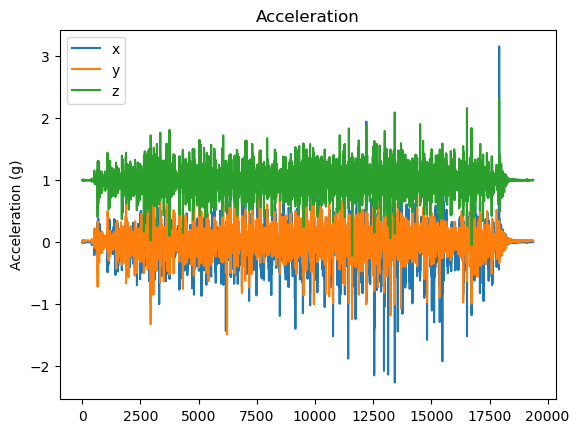

In [674]:
plt.title("Acceleration")
plt.plot(accel_ch0, label = "x")
plt.plot(accel_ch1, label = "y")
plt.plot(accel_ch2, label = "z")
plt.ylabel("Acceleration (g)")
plt.legend()

Text(0, 0.5, 'Acceleration (g)')

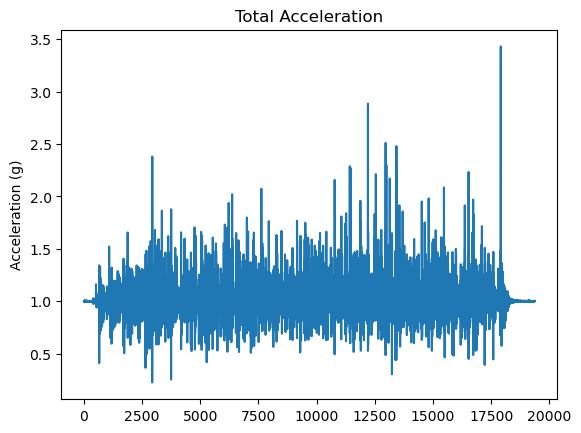

In [675]:
plt.title("Total Acceleration")
plt.plot(total_accel)
plt.ylabel("Acceleration (g)")

In [676]:
# Acceleration FFTs
def accel_fft(accel_ch, sampling_rate, ch_str):
    N = len(accel_ch)
    s = np.fft.fft(accel_ch - accel_ch.mean())
    freqs = np.fft.fftfreq(len(accel_ch), d=1/sampling_rate)

    positive_freqs = freqs[:len(accel_ch) // 2]
    A_fft = np.abs(s[:len(accel_ch) // 2]) / (N / 2)

    # Plot frequencies
    plt.plot(positive_freqs, A_fft)
    plt.title(f"{ch_str} FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Acceleration magnitude (g)")
    plt.xscale('log')
    #plt.yscale('log')

    plt.axvline(60, c='red', label='60Hz', alpha=0.4)
    plt.axvline(120, c='blue', label='120Hz', alpha=0.4)
    plt.axvline(180, c='green', label='180Hz', alpha=0.4)
    plt.legend()
    plt.show()

    return A_fft, positive_freqs

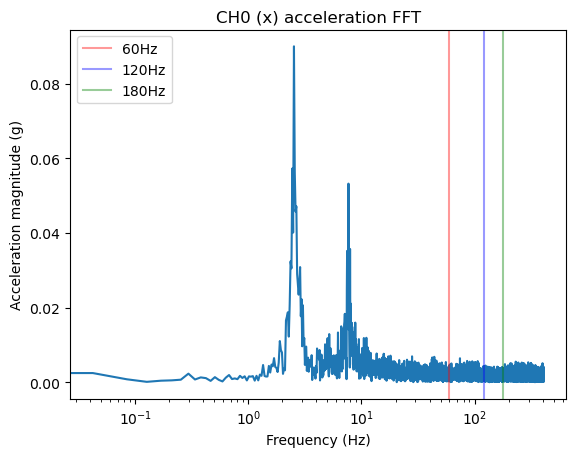

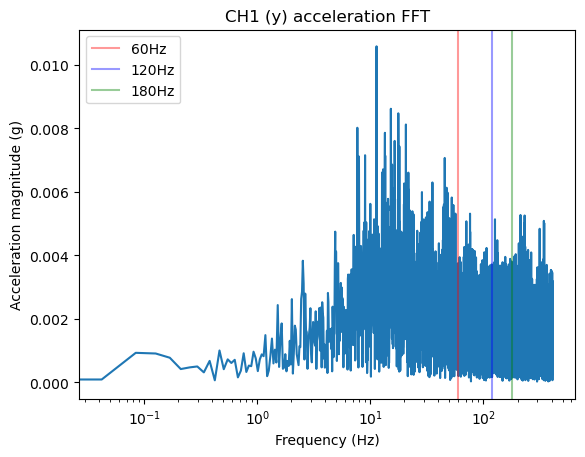

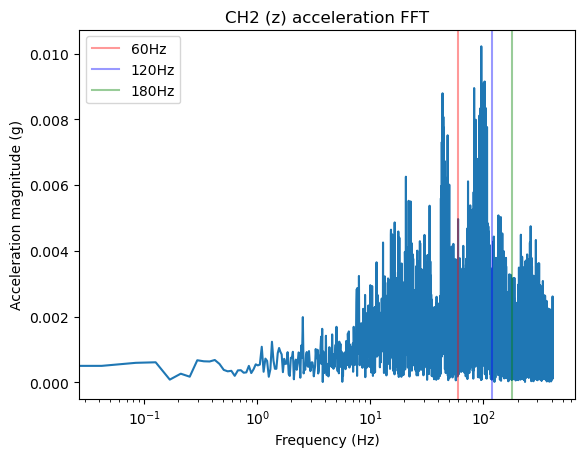

In [677]:
A_fft_ch0, freqs_ch0 = accel_fft(accel_ch0, mean_freq, "CH0 (x) acceleration")
A_fft_ch1, freqs_ch1 = accel_fft(accel_ch1, mean_freq, "CH1 (y) acceleration")
A_fft_ch2, freqs_ch2 = accel_fft(accel_ch2, mean_freq, "CH2 (z) acceleration")

In [678]:
def displacement_fft(A_fft, positive_freqs, ch_str):
    # Assume A_signal_g and positive_freqs are already defined
    A_ms2 = A_fft * 9.81  # convert g to m/s^2
    w = positive_freqs * np.pi * 2
    A_displacement = A_ms2[1:] / w[1:]**2

    # Create the figure and the first axis (for displacement)
    fig, ax1 = plt.subplots()

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Displacement amplitude (m)", color='b')
    ax1.plot(positive_freqs[1:], A_displacement, 'b-', label='Displacement')
    ax1.tick_params(axis='y', labelcolor='b')

    # Add vertical lines on ax1
    for f in [60, 120, 180]:
        ax1.axvline(f, c='k', alpha=0.4)

    ax1.axhline(0.01)
    # Create second y-axis for acceleration in g
    ax2 = ax1.twinx()
    ax2.set_yscale('log')
    ax2.set_ylabel("Acceleration amplitude (m / s^2)", color='r')
    ax2.plot(positive_freqs, A_ms2, 'r', label='Acceleration (m / s^2)')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title(f"{ch_str} Acceleration and Displacement")
    plt.tight_layout()
    plt.show()

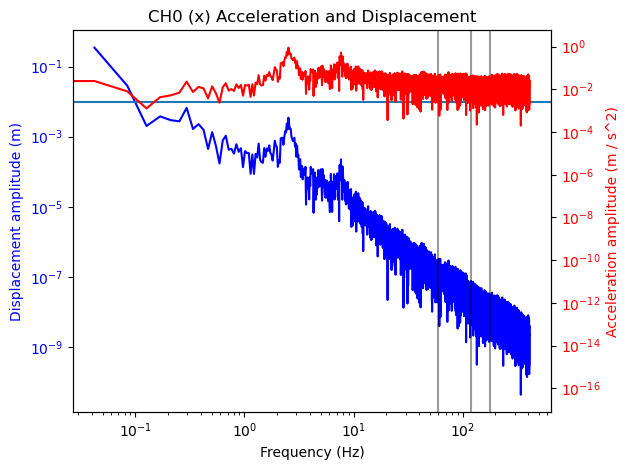

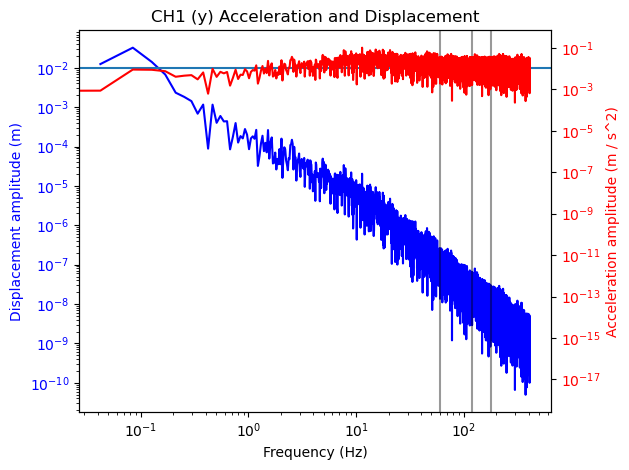

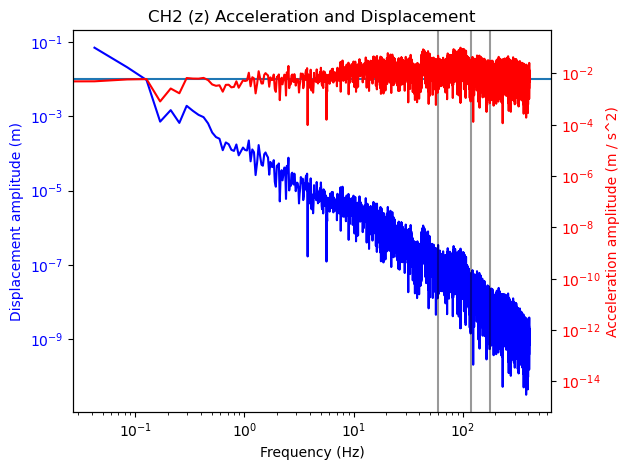

In [679]:
displacement_fft(A_fft_ch0, freqs_ch0, "CH0 (x)")
displacement_fft(A_fft_ch1, freqs_ch1, "CH1 (y)")
displacement_fft(A_fft_ch2, freqs_ch2, "CH2 (z)")